In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchdiffeq import odeint

from data_collector import Omie
from neural_ode import (ODEfunc, Decoder, LatentODE, RecurrentNN, RunningAverageMeter, get_batch, 
                        log_normal_pdf, normal_kl, plot_y_y_pred)

# Data Wrangling

In [3]:
# uncomment this to obtain day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)

In [4]:
df = pd.read_csv("day_ahead_market.csv", parse_dates=["date"], 
                  date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d"))

df = df[["date", "hour", "spain"]].rename(columns={"spain": "price"})

# remove time change price
df = df[df["hour"] != 25]
# set hour as zero based
df["hour"] = df["hour"] - 1

df["datetime"] = pd.to_datetime(df["date"]) + (df["hour"]).astype('timedelta64[h]')
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)

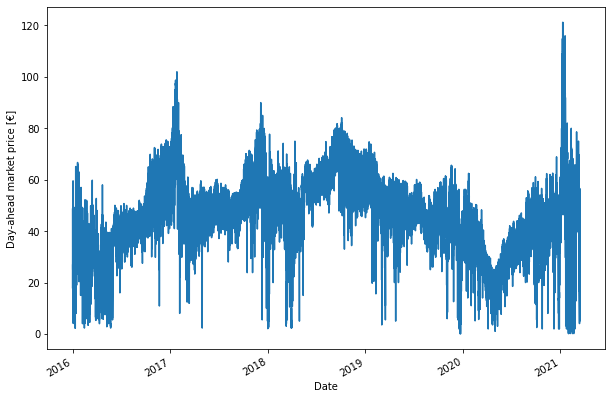

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
df[["price"]].plot(ax=ax, legend=False)
ax.set_xlabel("Date")
ax.set_ylabel("Day-ahead market price [€]")
plt.show()

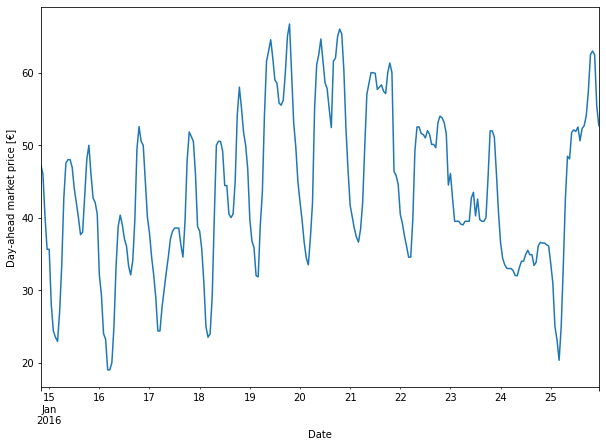

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
df[["price"]].loc["2016-01-14 20:00:00":"2016-01-25"].plot(ax=ax, legend=False)
ax.set_xlabel("Date")
ax.set_ylabel("Day-ahead market price [€]")
plt.show()

# NeuralODE - LatentODE framework

In [7]:
# split between train and test
split_date = "2021-01-01"
df_train, df_test = df[df["date"] < "2021-01-01"], df[df["date"] >= "2021-01-01"]

# standarise training set
mean_training = df_train["price"].mean()
std_training = df_train["price"].std()
print(f"Mean: {mean_training:.2f}; Std: {std_training:.2f}")

# define training tensor (y_true) -> shape (timesteps, y)
scaled_training = (df_train["price"] - mean_training) / std_training
y_true = torch.from_numpy(np.array(scaled_training, dtype=float)).reshape(-1, 1)
time_tensor = torch.arange(start=0, end=y_true.shape[0], step=1, dtype=torch.float)

Mean: 46.16; Std: 15.10


## Simple NeuralODE

In [ ]:
# strategy: start with a single point, fit on a small window until convergence, then increase window length and so on
# https://diffeqflux.sciml.ai/dev/examples/local_minima/#Iterative-Growing-Of-Fits-to-Reduce-Probability-of-Bad-Local-Minima
s = 3326
y0 = torch.from_numpy(np.stack([y_true[s]], axis=0)).float()

In [ ]:
# configure neural network architecture
obs_dim = y_true.shape[-1]
hidden_layer_1 = 16
hidden_layer_2 = 32
hidden_layer_3 = 64
hidden_layer_4 = 32
hidden_layer_5 = 16

lr = 1e-3
epochs = 1_000
time_step = 1
init_window_length = 3

simple_func = ODEfunc(obs_dim=obs_dim,
                      hidden_layer_1=hidden_layer_1,
                      hidden_layer_2=hidden_layer_2,
                      hidden_layer_3=hidden_layer_3,
                      hidden_layer_4=hidden_layer_4,
                      hidden_layer_5=hidden_layer_5
                     )

optimizer = torch.optim.Adam(simple_func.parameters(), lr=lr)
loss = torch.nn.MSELoss()

for j in range(4):
    
    trajectory_time = init_window_length + time_step*j
    batch = torch.from_numpy(np.stack([y_true[s: s+trajectory_time]], axis=0)).float()
    samp_ts = time_tensor[:trajectory_time].float()
    
    print("="*50)
    start = time.time()
    
    loss_meter = RunningAverageMeter()
    
    for i in range(1, epochs+1):
        
        optimizer.zero_grad()
        
        y_pred = odeint(func=simple_func, y0=y0, t=samp_ts)
        
        output = loss(y_pred.reshape(-1), batch.reshape(-1))
        output.backward()
        
        optimizer.step()
        loss_meter.update(output.item())
        
        if i == 1:
            log = f"Iteration {j}: {i:04d} | total loss {loss_meter.avg:.6f}"
            print(log)
            plot_y_y_pred(y_true=batch, y_pred=y_pred, t=samp_ts)
            
        if (i % 500 == 0) :
            end = time.time()
            training_time = (end-start) / 60
            log = f"Iteration {j}: {i:04d} | total loss {loss_meter.avg:.6f} | Time: {training_time:.2f} mins"
            print(log)
            plot_y_y_pred(y_true=batch, y_pred=y_pred, t=samp_ts)
            start = time.time()

## LatentODE

In [8]:
# configure neural architecture
obs_dim = y_true.shape[-1] # One-dimensional timeseries
latent_dim = 20 # Dimension of the latent space
rnn_hidden = 25 # Dimension of the hidden layer in the recurrentNN encoder 
nbatch = 1 # Number of samples in each minibatch
ode_hidden = 20 # Dimension of the hidden layer in the latent neural ODE
dec_hidden = 20 # Dimenson of the hidden layer in the NN decoder
noise_std = 0.5 # 

lr = 1e-3 # learning rate
#TODO: Adaptative epochs, the longer the trajectory the longer the epochs
epochs = 800 # number of epochs
trajectory_time_base = 24 # number of timesteps that enter into the encoder and the neural ODE must integrate
time_step = 6
#s = 3320
s = 40000

In [9]:
# define architecture
rnn = RecurrentNN(obs_dim=obs_dim, latent_dim=latent_dim, nhidden=rnn_hidden, nbatch=nbatch)
latent_func = LatentODE(latent_dim=latent_dim, nhidden=ode_hidden)
dec = Decoder(latent_dim=latent_dim, obs_dim=obs_dim, nhidden=dec_hidden)

params = (list(rnn.parameters()) + list(latent_func.parameters()) + list(dec.parameters()))

optimizer = torch.optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()

Iteration 0: 0001 | total loss -25.134155


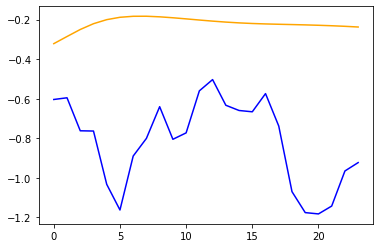

Iteration 0: 0400 | total loss -7.852487 | Time: 0.43 mins


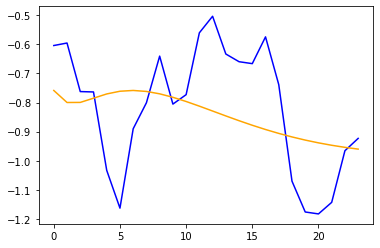

Iteration 0: 0800 | total loss -6.710917 | Time: 0.49 mins


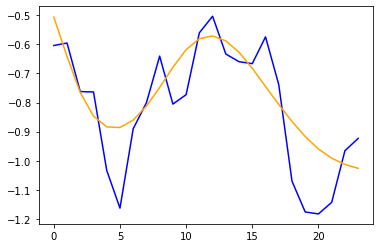

Prediction


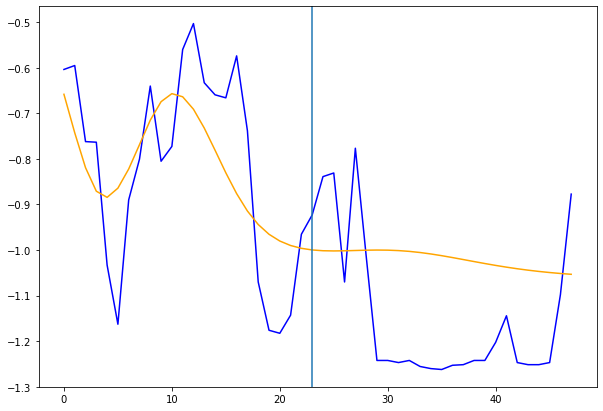

Iteration 5: 0001 | total loss -19.518764


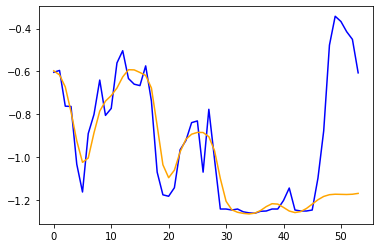

Iteration 5: 0400 | total loss -13.934479 | Time: 2.05 mins


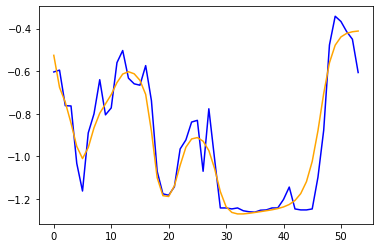

Iteration 5: 0800 | total loss -13.276622 | Time: 2.23 mins


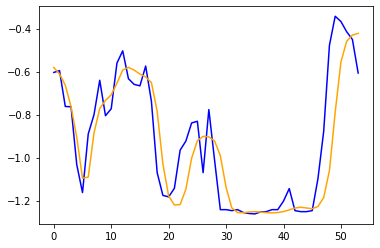

Prediction


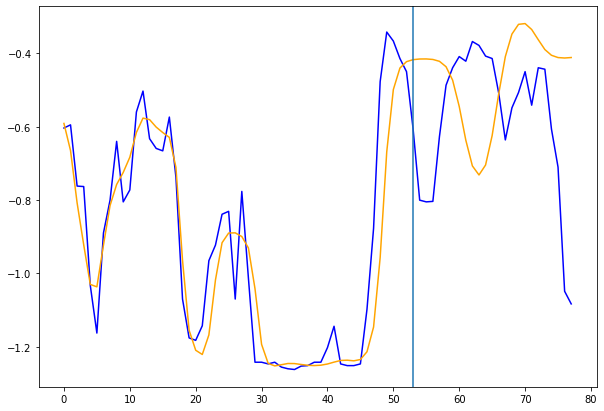

Iteration 10: 0001 | total loss -20.991659


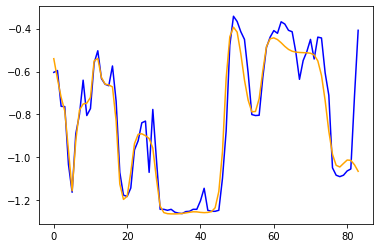

Iteration 10: 0400 | total loss -20.647620 | Time: 4.13 mins


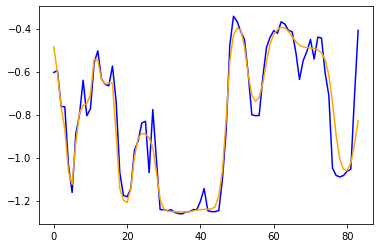

Iteration 10: 0800 | total loss -20.671495 | Time: 4.28 mins


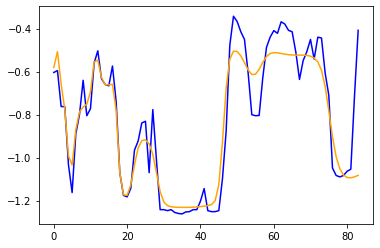

Prediction


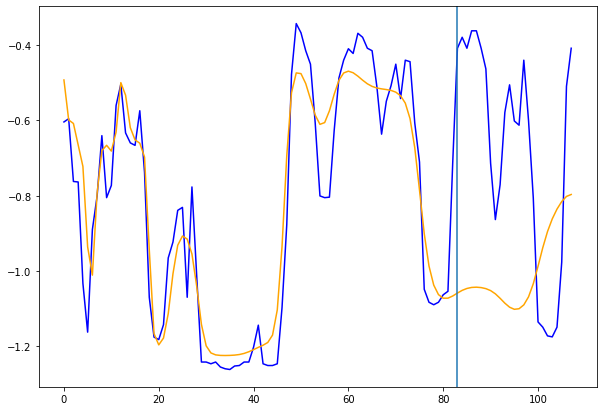

Iteration 15: 0001 | total loss -28.104277


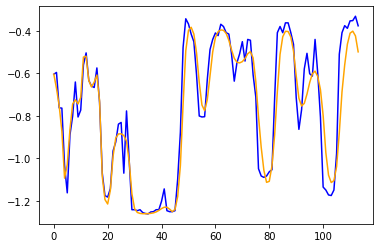

Iteration 15: 0400 | total loss -27.284231 | Time: 4.46 mins


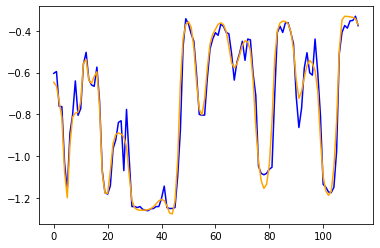

Iteration 15: 0800 | total loss -27.473852 | Time: 4.82 mins


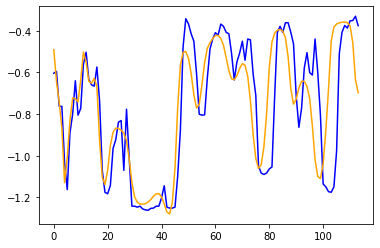

Prediction


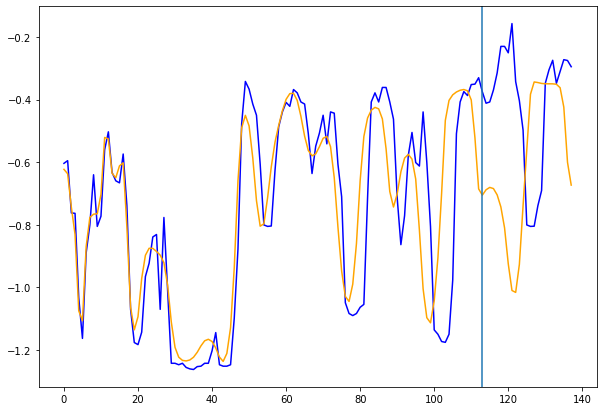

Iteration 20: 0001 | total loss -33.250565


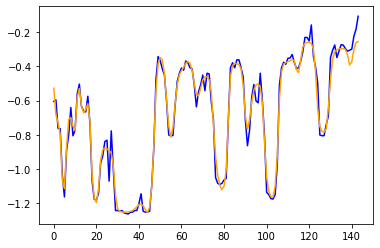

Iteration 20: 0400 | total loss -34.456424 | Time: 5.59 mins


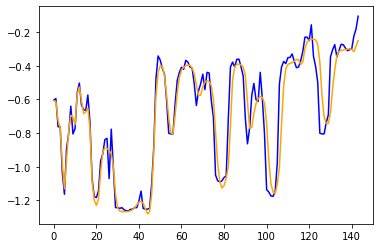

Iteration 20: 0800 | total loss -34.169590 | Time: 5.57 mins


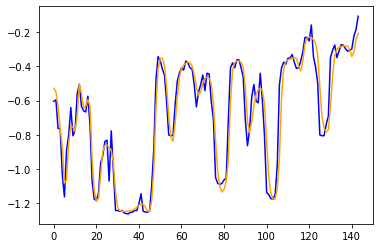

Prediction


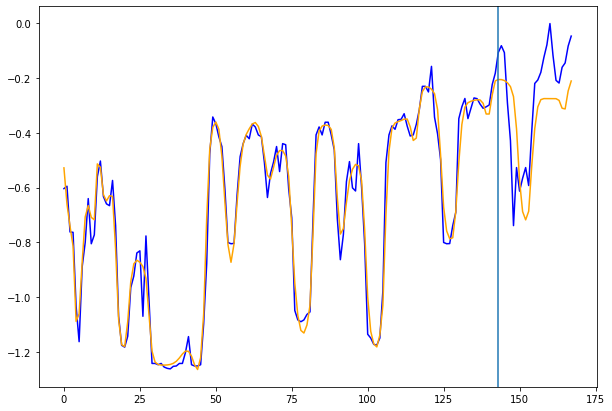

Iteration 25: 0001 | total loss -47.138138


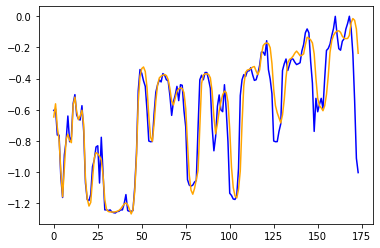

Iteration 25: 0400 | total loss -41.962309 | Time: 7.16 mins


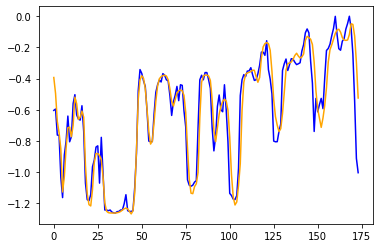

Iteration 25: 0800 | total loss -41.473816 | Time: 8.06 mins


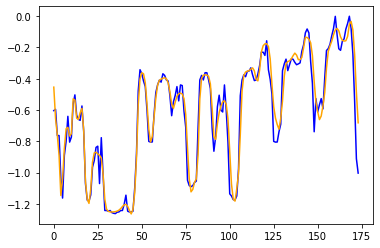

Prediction


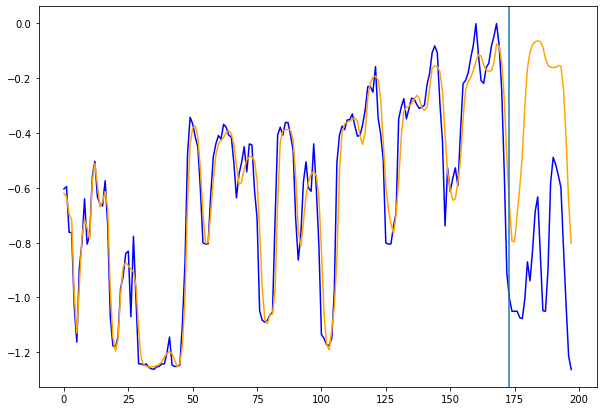

Iteration 30: 0001 | total loss -54.703182


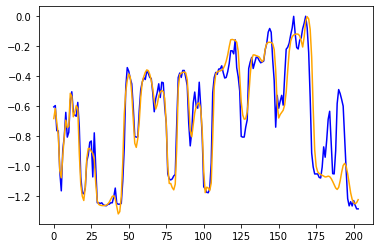

Iteration 30: 0400 | total loss -49.383585 | Time: 9.40 mins


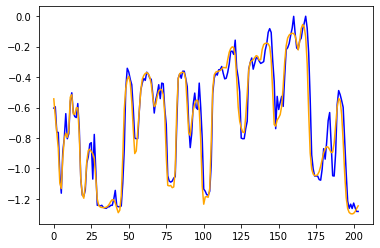

Iteration 30: 0800 | total loss -48.750394 | Time: 11.13 mins


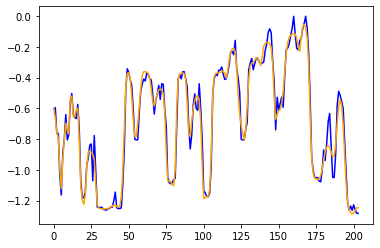

Prediction


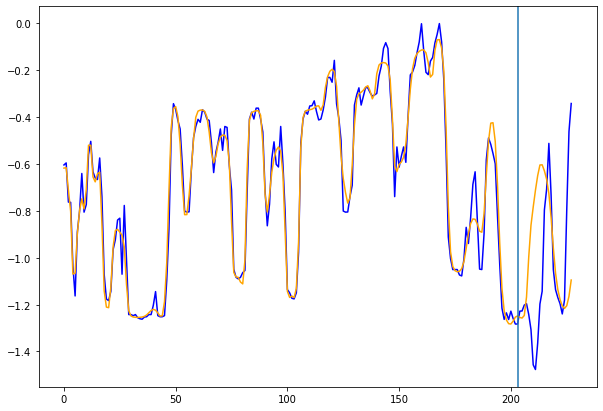

In [10]:
for j in range(31):
    trajectory_time = trajectory_time_base + time_step*j
    batch = torch.from_numpy(np.stack([y_true[s: s+trajectory_time]], axis=0)).float()
    samp_ts = time_tensor[:trajectory_time].float()
    
    start = time.time()
    loss_meter = RunningAverageMeter()
    
    for i in range(1, epochs+1):

        optimizer.zero_grad()

        # infer q(z_0) running the RecurrentNN in reversed order
        h = rnn.init_hidden()
        for t in reversed(range(trajectory_time)):
            obs = batch[:, t, :]  # obs shape: (nbatch, obs_dim)
            # feed-forward the rnn with the obs for new t and resulting h from previous t evaluation
            out, h = rnn.forward(x=obs, h=h)

        # last out corresponds to t0, shape: (nbatch, latent_dim * 2)
        # latent space parameters are q mean and log var
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]

        # sample z0 from q distribution using reparametrization trick
        # z = mu + sigma * eps, where eps is drawn from a N(0, I)
        epsilon = torch.randn(qz0_mean.size())
        z0 = qz0_mean + epsilon * torch.exp(0.5 * qz0_logvar)

        # compute ODE in latent space for samp_ts steps and initial value z0
        # shape after permute: (nbatch, nsample, latent_dim)
        pred_z = odeint(func=latent_func, y0=z0, t=samp_ts).permute(1, 0, 2)

        # decode pred_z from latent space to observation space, pred_x shape: (nbatch, nsamples, obs_dim)
        pred_x = dec(pred_z)

        # compute loss function
        # noise_log_var shape: (nbatch, nsample, nobs)
        noise_std_ = torch.zeros(pred_x.size()) + noise_std
        noise_logvar = 2. * torch.log(noise_std_)

        # logpx, shape: (nbatch)
        logpx = log_normal_pdf(x=batch, mean=pred_x, logvar=noise_logvar).sum(-1).sum(-1)

        # p(z0) is assumed to follow N(0, I)
        pz0_mean = torch.zeros(z0.size())
        pz0_logvar = torch.zeros(z0.size())

        analytic_kl = normal_kl(mu1=qz0_mean, logvar1=qz0_logvar, mu2=pz0_mean, logvar2=pz0_logvar).sum(-1)

        # maximising ELBO is similar to minimising Kullack-Leibler(KL) divergence between Q and posterior
        # p(z|x). However, instead of using the posterior, it can be reformulated using Bayes theorem.
        # Assuming that P(z|x) (posterior) = P(x|z) (likelihood) * P(z) (prior) / P(x)
        # ELBO becomes the log-likelihood p(x|z) - KL(Q,P)| max ELBO = min (-1) ELBO
        # Resources:
        # https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
        # https://en.wikipedia.org/wiki/Evidence_lower_bound
        loss = torch.mean(-logpx + analytic_kl, dim=0)

        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
        
        if j % 5 == 0: 
            if i == 1:
                print("="*50)
                log = f"Iteration {j}: {i:04d} | total loss {-loss_meter.avg:.6f}"
                print(log)
                plot_y_y_pred(y_true=batch, y_pred=pred_x, t=samp_ts)

            if i % 400 == 0:
                end = time.time()
                training_time = (end-start) / 60
                log = f"Iteration {j}: {i:04d} | total loss {-loss_meter.avg:.6f} | Time: {training_time:.2f} mins"
                print(log)
                plot_y_y_pred(y_true=batch, y_pred=pred_x, t=samp_ts)
                start = time.time()
                
            if i == epochs:
                
                print("Prediction")
                
                # test learnt dyanmic
                trajectory_time_test = trajectory_time + int(trajectory_time_base*1)
                batch_test = torch.from_numpy(np.stack([y_true[s: s+trajectory_time_test]], axis=0)).float()
                samp_ts_test = time_tensor[:trajectory_time_test].float()
                
                with torch.no_grad():
    
                    h = rnn.init_hidden()
                    for t in reversed(range(samp_ts.shape[0])):
                        obs = batch[:, t, :]
                        out, h = rnn.forward(x=obs, h=h)

                    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
                    epsilon = torch.randn(qz0_mean.size())
                    z0 = qz0_mean + epsilon * torch.exp(0.5 * qz0_logvar)

                    pred_z = odeint(func=latent_func, y0=z0, t=samp_ts_test).permute(1, 0, 2)

                    y_pred = dec(pred_z)
                    
                fig, ax = plt.subplots(figsize=(10, 7))
                ax.plot(samp_ts_test, batch_test.reshape(-1), color="blue")
                ax.plot(samp_ts_test, y_pred.reshape(-1), color="orange")
                ax.axvline(x=samp_ts.max().item())
                plt.show()
                
    

In [11]:
# test learnt dyanmic
trajectory_time_test = trajectory_time + int(trajectory_time_base*4)
batch = torch.from_numpy(np.stack([y_true[s: s+trajectory_time]], axis=0)).float()
batch_test = torch.from_numpy(np.stack([y_true[s: s+trajectory_time_test]], axis=0)).float()
samp_ts = time_tensor[:trajectory_time].float()
samp_ts_test = time_tensor[:trajectory_time_test].float()

In [12]:
with torch.no_grad():
    
    h = rnn.init_hidden()
    for t in reversed(range(samp_ts.shape[0])):
        obs = batch[:, t, :]
        out, h = rnn.forward(x=obs, h=h)
        
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size())
    z0 = qz0_mean + epsilon * torch.exp(0.5 * qz0_logvar)
    
    pred_z = odeint(func=latent_func, y0=z0, t=samp_ts_test).permute(1, 0, 2)
    
    y_pred = dec(pred_z)

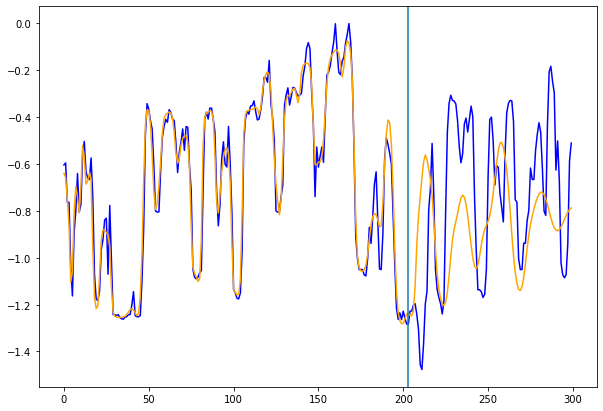

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(samp_ts_test, batch_test.reshape(-1), color="blue")
ax.plot(samp_ts_test, y_pred.reshape(-1), color="orange")
ax.axvline(x=samp_ts.max().item())
plt.show()